In [39]:
from __future__ import division
import sys, os, glob
import numpy as np
from scipy import stats
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import LambdaCDM
import matplotlib as mpl
from matplotlib import pyplot as plt, rc
import seaborn as sns
import h5py
import pandas as pd
sys.path.insert(0, '/cosma5/data/dp004/dc-beck3/lib/')
import read_hdf5
sys.path.insert(0, '/cosma5/data/dp004/dc-beck3/StrongLensing/LensingPostProc/lib/')
import matching
import lens
import lpp_pyfuncs


# Disable
def blockprint():
    sys.stdout = open(os.devnull, 'w')


# Restore
def enableprint():
    sys.stdout = sys.__stdout__

In [73]:
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 6      # major tick size in points
plt.rcParams['xtick.minor.size'] = 3      # minor tick size in points
plt.rcParams['xtick.major.width'] = 3    # major tick width in points
plt.rcParams['xtick.minor.width'] = 3    # minor tick width in points
plt.rcParams['ytick.major.size'] = 6      # major tick size in points
plt.rcParams['ytick.minor.size'] = 3      # minor tick size in points
plt.rcParams['ytick.major.width'] = 3    # major tick width in points
plt.rcParams['ytick.minor.width'] = 3    # minor tick width in points
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 20

In [74]:
# Load Files
simname = ['F5', 'F6', 'GR']
snapnum = 39

simdir = '/cosma6/data/dp004/dc-arno1/SZ_project/full_physics/'\
         'L62_N512_%s_kpc/'
lmdir = '/cosma5/data/dp004/dc-beck3/StrongLensing/LensingMap/'\
        'full_physics/Subfind/L62_N512_%s_kpc/Box/LM_%s_zl020zs409.pickle'
hfdir = '/cosma6/data/dp004/dc-arno1/SZ_project/full_physics/'\
        'L62_N512_%s_kpc/'
lppdir = '/cosma5/data/dp004/dc-beck3/StrongLensing/LensingPostProc/'\
         'full_physics/Subfind/Box/LPPBox_%s_lens_zl020zs409.h5'

iPTF16geu = {'Rein' : 1.05,                              #[arcsec]
             'Mein' : np.array([1.7*1e10, 0.06, 0.06]),  #[Msol]
             'Vrms' : np.array([163, 41, 27]),           #[km/s]
             'e' : np.array([0.15, 0.07, 0.07]),         # Ellipticity
             'mu' : 52}

## Subhalo Properties

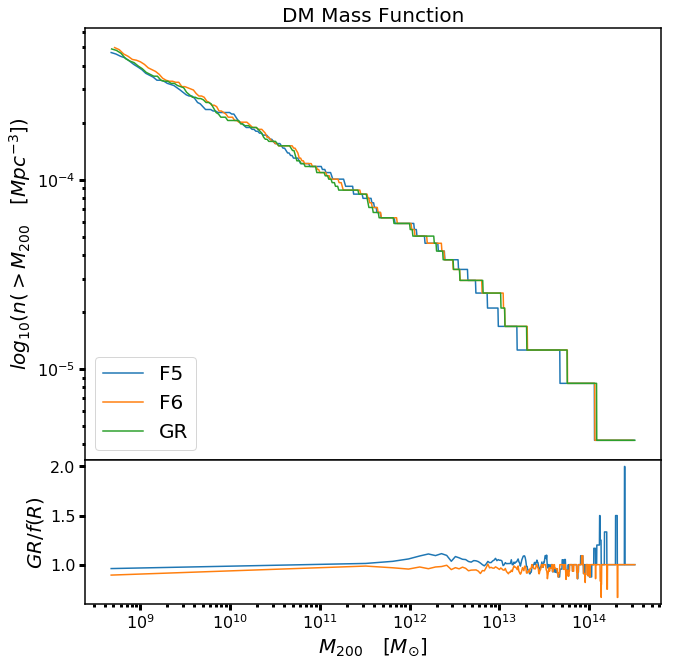

In [64]:
f1 = plt.figure()
frame1=f1.add_axes((.1,.3,.8,.6))
plt.title('DM Mass Function')
plt.loglog()
for ff in range(len(simname)):
    blockprint()
    lppfile = lppdir % simname[ff]
    
    # Subhalo Data
    s = read_hdf5.snapshot(snapnum, simdir % simname[ff])
    s.group_catalog(["SubhaloMass", "SubhaloMassInHalfRadType"])
    subhalos = pd.DataFrame({'Mass' : s.cat['SubhaloMass']})

        
    hist, bin_edges = np.histogram(subhalos['Mass'].values,
                                   bins=1000)
    hist = np.cumsum(hist[::-1])/62**3
    bin_edges = bin_edges[:-1]
    bin_edges = bin_edges[::-1]
    
    indx = np.where(bin_edges > 1e13)[0]
    
    plt.plot(bin_edges[indx], hist[indx], label=simname[ff])
    plt.ylabel(r'$log_{10}(n(> M_{200} \quad [Mpc^{-3}])$')
    enableprint()
    
    if simname[ff] == 'GR':
        hist_gr = hist
    elif simname[ff] == 'F6':
        hist_f6 = hist
    elif simname[ff] == 'F5':
        hist_f5 = hist

plt.legend(loc=3)

frame2=f1.add_axes((.1, .1, .8, .2))
#plt.loglog()
plt.xscale('log')
plt.plot(bin_edges, hist_gr/hist_f5)
plt.plot(bin_edges, hist_gr/hist_f6)
plt.ylabel(r'$GR/f(R)$')    
plt.xlabel(r'$M_{200} \quad [M_{\odot}]$')
plt.show()

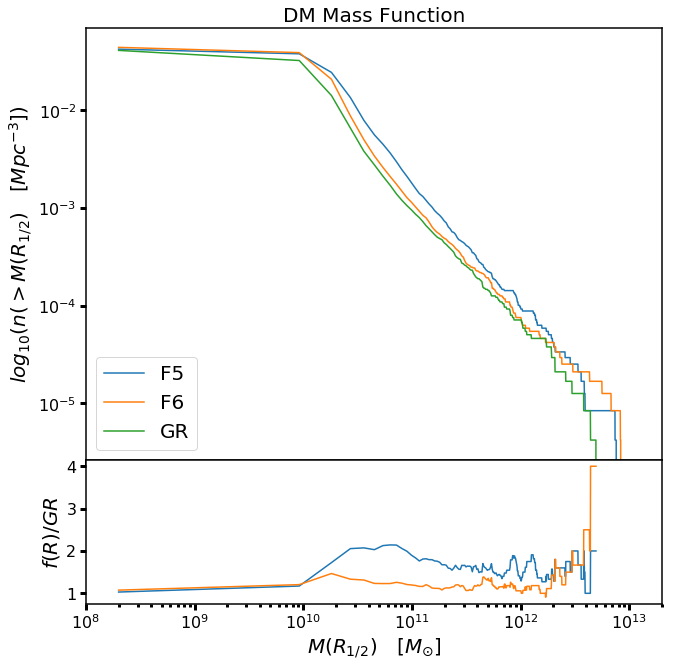

In [129]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
lstyle = ['-', '--', ':']
xmin = 1e8
xmax = 2e13

f1 = plt.figure()
frame1=f1.add_axes((.1,.3,.8,.6))
plt.title('DM Mass Function')
plt.loglog()
for ff in range(len(simname)):
    lppfile = lppdir % simname[ff]
    
    #blockprint()
    s = read_hdf5.snapshot(snapnum, simdir % simname[ff])
    s.group_catalog(["SubhaloMass", "SubhaloMassInHalfRadType"])
    subhalos = pd.DataFrame({'Mass' : s.cat['SubhaloMass'],
                             'DMMass' : s.cat['SubhaloMassInHalfRadType'][:, 1],
                             'GasMass' : s.cat['SubhaloMassInHalfRadType'][:, 0],
                             'StellarMass' : s.cat['SubhaloMassInHalfRadType'][:, 4]})
    subhalos = subhalos[subhalos['Mass'] > 1e11]
    
    # DM
    subhalos = subhalos[subhalos['DMMass'] > 0]
    hist, bin_edges = np.histogram(
        subhalos['DMMass'].values, range=[2e8, 9e12],
        bins=1000)
    hist = np.cumsum(hist[::-1])/62**3
    bin_edges = bin_edges[:-1]
    bin_edges = bin_edges[::-1]
    #threshold = 200
    #bin_edges = bin_edges[threshold:]
    #hist = hist[:-threshold]
    
    plt.plot(bin_edges, hist,
             color=colors[ff], label=simname[ff])

    if simname[ff] == 'GR':
        hist_gr = hist
    elif simname[ff] == 'F6':
        hist_f6 = hist
    elif simname[ff] == 'F5':
        hist_f5 = hist

plt.xlim(xmin, xmax)
#plt.ylim(1e-6, 3e-1)
plt.ylabel(r'$log_{10}(n(> M(R_{1/2}) \quad [Mpc^{-3}])$')
plt.legend(loc=3)
frame1.set_xticklabels([])
frame1.minorticks_off()

frame2=f1.add_axes((.1, .1, .8, .2))
plt.xscale('log')
plt.plot(bin_edges, hist_f5/hist_gr)
plt.plot(bin_edges, hist_f6/hist_gr)
plt.xlim(xmin, xmax)
plt.xlabel(r'$M(R_{1/2}) \quad [M_{\odot}]$')
plt.ylabel(r'$f(R)/GR$')
#plt.rcParams['figure.figsize'] = [10, 10]
plt.savefig('DMMassFunction_zoom.png',
            bbox_inches='tight')

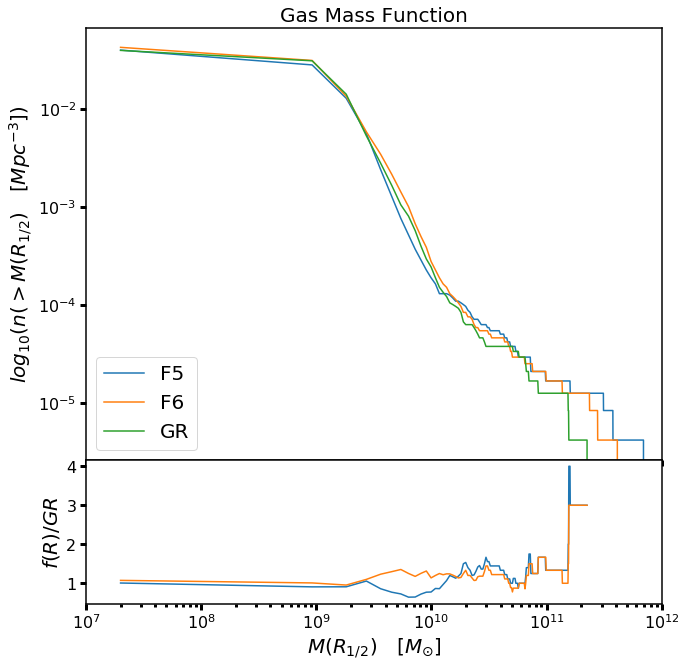

In [130]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
lstyle = ['-', '--', ':']
xmin = 1e7
xmax = 1e12

f1 = plt.figure()
frame1=f1.add_axes((.1,.3,.8,.6))
plt.title('Gas Mass Function')
plt.loglog()
for ff in range(len(simname)):
    lppfile = lppdir % simname[ff]
    
    #blockprint()
    s = read_hdf5.snapshot(snapnum, simdir % simname[ff])
    s.group_catalog(["SubhaloMass", "SubhaloMassInHalfRadType"])
    subhalos = pd.DataFrame({'Mass' : s.cat['SubhaloMass'],
                             'DMMass' : s.cat['SubhaloMassInHalfRadType'][:, 1],
                             'GasMass' : s.cat['SubhaloMassInHalfRadType'][:, 0],
                             'StellarMass' : s.cat['SubhaloMassInHalfRadType'][:, 4]})
    subhalos = subhalos[subhalos['Mass'] > 1e11]
    
    # Gas
    subhalos = subhalos[subhalos['GasMass'] > 0]
    hist, bin_edges = np.histogram(
        subhalos['GasMass'].values, range=[2e7, 9e11], bins=1000)
    hist = np.cumsum(hist[::-1])/62**3
    bin_edges = bin_edges[:-1]
    bin_edges = bin_edges[::-1]
    plt.plot(bin_edges, hist,
             color=colors[ff], label=simname[ff])
    
    plt.xlim(xmin, xmax)
    plt.ylabel(r'$log_{10}(n(> M(R_{1/2}) \quad [Mpc^{-3}])$')
    
    
    if simname[ff] == 'GR':
        hist_gr = hist
    elif simname[ff] == 'F6':
        hist_f6 = hist
    elif simname[ff] == 'F5':
        hist_f5 = hist
        
plt.legend(loc=3)
frame1.set_xticklabels([])
frame1.minorticks_off()

frame2=f1.add_axes((.1, .1, .8, .2))
plt.xscale('log')
plt.plot(bin_edges, hist_f5/hist_gr)
plt.plot(bin_edges, hist_f6/hist_gr)
plt.xlim(xmin, xmax)
plt.xlabel(r'$M(R_{1/2}) \quad [M_{\odot}]$')
plt.ylabel(r'$f(R)/GR$')
#plt.rcParams['figure.figsize'] = [10, 10]
plt.savefig('GasMassFunction_zoom.png',
            bbox_inches='tight')

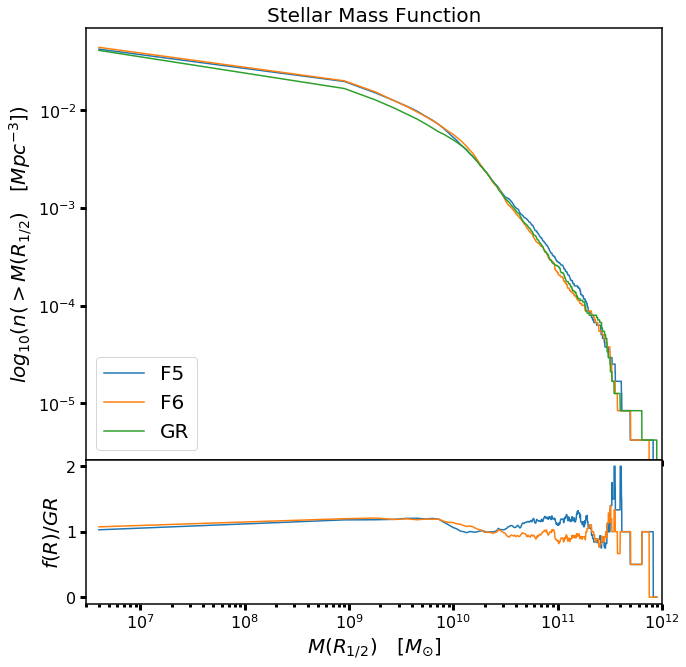

In [131]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
lstyle = ['-', '--', ':']
xmin = 3e6
xmax = 1e12

f1 = plt.figure()
frame1=f1.add_axes((.1,.3,.8,.6))
plt.title('Stellar Mass Function')
plt.loglog()
for ff in range(len(simname)):
    lppfile = lppdir % simname[ff]
    
    #blockprint()
    s = read_hdf5.snapshot(snapnum, simdir % simname[ff])
    s.group_catalog(["SubhaloMass", "SubhaloMassInHalfRadType"])
    subhalos = pd.DataFrame({'Mass' : s.cat['SubhaloMass'],
                             'DMMass' : s.cat['SubhaloMassInHalfRadType'][:, 1],
                             'GasMass' : s.cat['SubhaloMassInHalfRadType'][:, 0],
                             'StellarMass' : s.cat['SubhaloMassInHalfRadType'][:, 4]})
    subhalos = subhalos[subhalos['Mass'] > 1e11]
    
    # Stars
    subhalos = subhalos[subhalos['StellarMass'] > 0]
    hist, bin_edges = np.histogram(
        subhalos['StellarMass'].values, range=[4e6, 9e11], bins=1000)
    hist = np.cumsum(hist[::-1])/62**3
    bin_edges = bin_edges[:-1]
    bin_edges = bin_edges[::-1]
    plt.plot(bin_edges, hist,
             color=colors[ff], label=simname[ff])
    plt.xlim(xmin, xmax)
    plt.ylabel(r'$log_{10}(n(> M(R_{1/2}) \quad [Mpc^{-3}])$')
    
    if simname[ff] == 'GR':
        hist_gr = hist
    elif simname[ff] == 'F6':
        hist_f6 = hist
    elif simname[ff] == 'F5':
        hist_f5 = hist
        
plt.legend(loc=3)
frame1.set_xticklabels([])
frame1.minorticks_off()

frame2=f1.add_axes((.1, .1, .8, .2))
plt.xscale('log')
plt.plot(bin_edges, hist_f5/hist_gr)
plt.plot(bin_edges, hist_f6/hist_gr)
plt.xlim(xmin, xmax)
plt.xlabel(r'$M(R_{1/2}) \quad [M_{\odot}]$')
plt.ylabel(r'$f(R)/GR$')
plt.savefig('StellarMassFunction_zoom.png',
            bbox_inches='tight')

# Zoom on mass selection

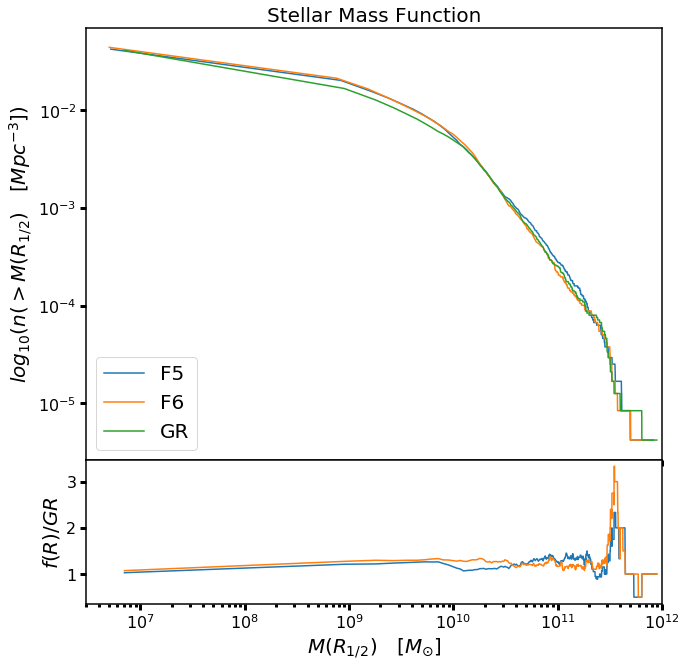

In [128]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
lstyle = ['-', '--', ':']
xmin = 3e6
xmax = 1e12

f1 = plt.figure()
frame1=f1.add_axes((.1,.3,.8,.6))
plt.title('Stellar Mass Function')
plt.loglog()
for ff in range(len(simname)):
    lppfile = lppdir % simname[ff]
    
    #blockprint()
    s = read_hdf5.snapshot(snapnum, simdir % simname[ff])
    s.group_catalog(["SubhaloMass", "SubhaloMassInHalfRadType"])
    subhalos = pd.DataFrame({'Mass' : s.cat['SubhaloMass'],
                             'DMMass' : s.cat['SubhaloMassInHalfRadType'][:, 1],
                             'GasMass' : s.cat['SubhaloMassInHalfRadType'][:, 0],
                             'StellarMass' : s.cat['SubhaloMassInHalfRadType'][:, 4]})
    subhalos = subhalos[subhalos['Mass'] > 1e11]
    
    # Stars
    subhalos = subhalos[subhalos['StellarMass'] > 0]
    hist, bin_edges = np.histogram(
        subhalos['StellarMass'].values, #range=[4e6, 9e11],
        bins=1000)
    hist = np.cumsum(hist[::-1])/62**3
    bin_edges = bin_edges[:-1]
    bin_edges = bin_edges[::-1]
    plt.plot(bin_edges, hist,
             color=colors[ff], label=simname[ff])
    plt.xlim(xmin, xmax)
    plt.ylabel(r'$log_{10}(n(> M(R_{1/2}) \quad [Mpc^{-3}])$')
    
    if simname[ff] == 'GR':
        hist_gr = hist
    elif simname[ff] == 'F6':
        hist_f6 = hist
    elif simname[ff] == 'F5':
        hist_f5 = hist
        
plt.legend(loc=3)
frame1.set_xticklabels([])
frame1.minorticks_off()

frame2=f1.add_axes((.1, .1, .8, .2))
plt.xscale('log')
plt.plot(bin_edges, hist_f5/hist_gr)
plt.plot(bin_edges, hist_f6/hist_gr)
plt.xlim(xmin, xmax)
plt.xlabel(r'$M(R_{1/2}) \quad [M_{\odot}]$')
plt.ylabel(r'$f(R)/GR$')
plt.savefig('StellarMassFunction.png',
            bbox_inches='tight')